# UD120 - Classifing Enron POIs

## Introduction

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives.

The objective of this project is to build an algorithm to identify Enron Employees who may have committed fraud based on the public Enron financial and email dataset.

### Data Structure

The dataset provided for this projection is a dictionary containing combined Enron email and financial data. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

POI label: [‘poi’] (boolean, represented as integer)

### Report Structure

Report outlines the model development process in the following order:

* Data exploration
* Outlier detection

## Data Exploration

Text....

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
from ggplot import *
from feature_format import featureFormat, targetFeatureSplit

In [2]:
## initiate seaborn plotting
import matplotlib.pyplot as plt
import seaborn as sns
p = sns.color_palette()

In [86]:
## import dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    my_dataset = pickle.load(data_file)

In [88]:
df = pd.DataFrame.from_dict(my_dataset,orient='index')
df = df.replace('NaN',np.nan)

### Outlier Detection

In [172]:
df['name'] = df.index
df = df.reset_index()
df['index'] = df.index

In [90]:
df.head()

,index,to_messages,restricted_stock_deferred,poi,deferred_income,salary,total_stock_value,expenses,deferral_payments,director_fees,...,from_poi_to_this_person,long_term_incentive,from_this_person_to_poi,total_payments,exercised_stock_options,other,from_messages,bonus,shared_receipt_with_poi,name
0,0,2902,-126027,False,-3081055,201955,1729541,13868,2869717,NaN,...,47,304805,65,4484442,1729541,152,2195,4175000,1407,ALLEN PHILLIP K
1,1,NaN,NaN,False,NaN,NaN,257817,3486,178980,NaN,...,NaN,NaN,NaN,182466,257817,NaN,NaN,NaN,NaN,BADUM JAMES P
2,2,566,-560222,False,-5104,477,5243487,56301,NaN,NaN,...,39,NaN,0,916197,4046157,864523,29,NaN,465,BANNANTINE JAMES M
3,3,NaN,NaN,False,-1386055,267102,10623258,11200,1295738,NaN,...,NaN,1586055,NaN,5634343,6680544,2660303,NaN,1200000,NaN,BAXTER JOHN C
4,4,NaN,-82782,False,-201641,239671,63014,129142,260455,NaN,...,NaN,NaN,NaN,827696,NaN,69,NaN,400000,NaN,BAY FRANKLIN R


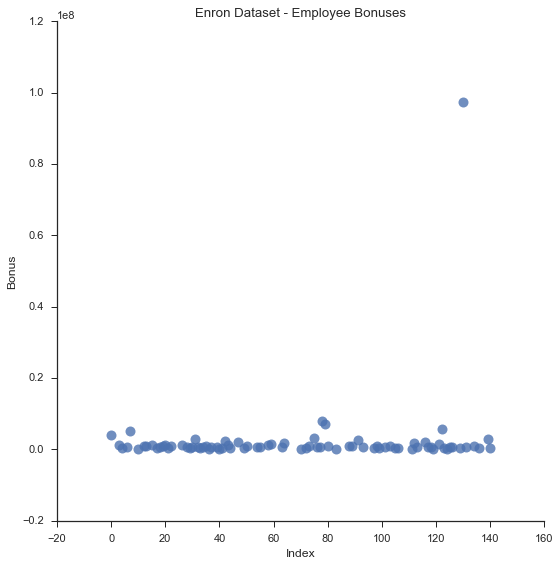

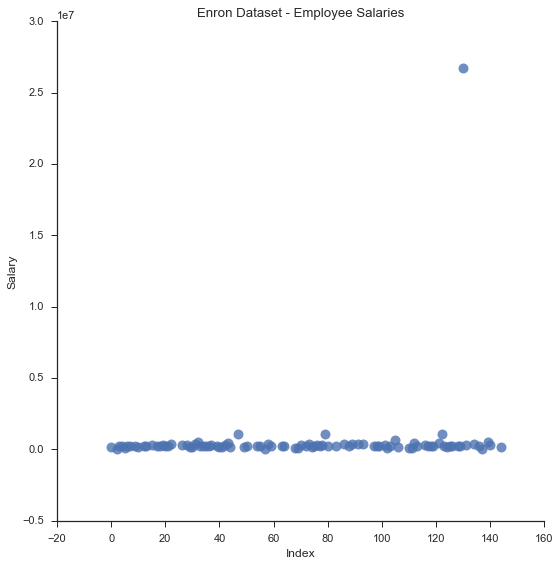

In [91]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

sns.lmplot('index', 'bonus', 
           data=df,
           fit_reg=False, 
           scatter_kws={"marker": "D", 
                        "s": 100},
          size=8);
plt.title('Enron Dataset - Employee Bonuses');
plt.xlabel('Index');
plt.ylabel('Bonus');

sns.lmplot('index', 'salary', 
           data=df,
           fit_reg=False, 
           scatter_kws={"marker": "D", 
                        "s": 100},
          size=8);
plt.title('Enron Dataset - Employee Salaries');
plt.xlabel('Index');
plt.ylabel('Salary');

In [92]:
# remove outlier
my_dataset.pop('TOTAL');

In [93]:
## recreate dataframe
df = pd.DataFrame.from_dict(my_dataset,orient='index')
df = df.replace('NaN',np.nan)
df['name'] = df.index
df = df.reset_index()
df['index'] = df.index

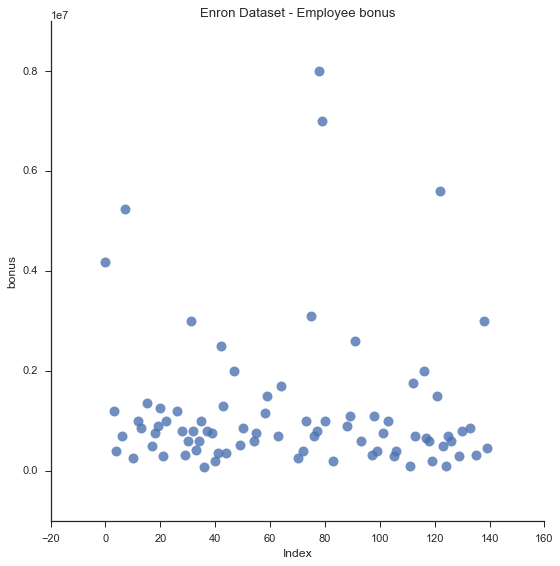

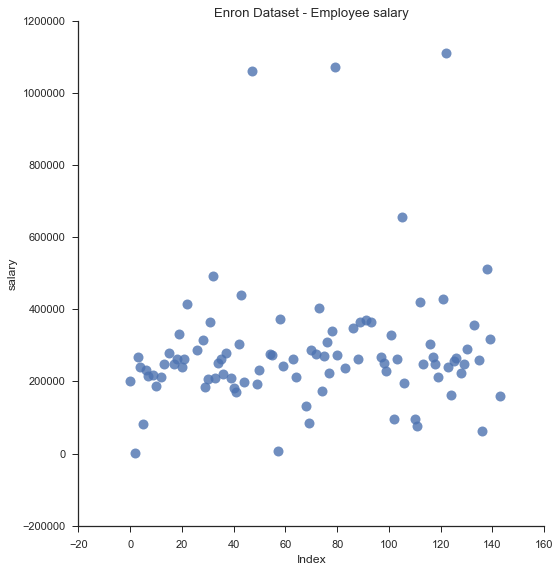

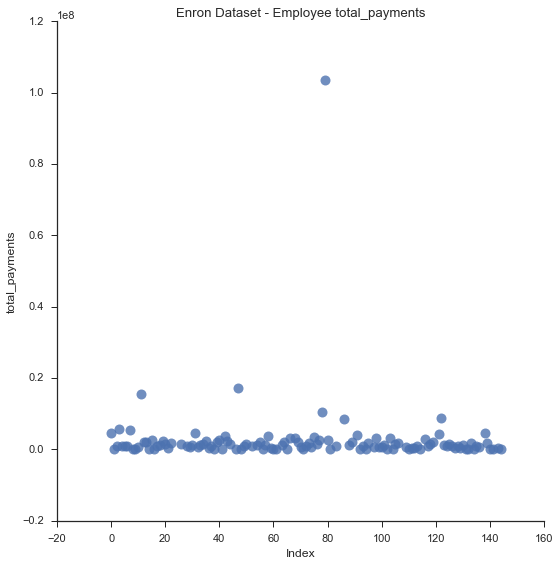

In [155]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")


for payment_feature in ['bonus','salary','total_payments']:

    sns.lmplot('index', payment_feature, 
               data=df,
               fit_reg=False, 
               scatter_kws={"marker": "D", 
                            "s": 100},
              size=8);
    plt.title('Enron Dataset - Employee %s' % payment_feature);
    plt.xlabel('Index');
    plt.ylabel(payment_feature);

In [153]:
## other potential outliers
df[(df.salary > 1000000) | (df.bonus > 5000000)][['bonus','salary','poi','total_payments']]

,bonus,salary,poi,total_payments
BELDEN TIMOTHY N,5249999,213999,1,5501630
FREVERT MARK A,2000000,1060932,0,17252530
LAVORATO JOHN J,8000000,339288,0,10425757
LAY KENNETH L,7000000,1072321,1,103559793
SKILLING JEFFREY K,5600000,1111258,1,8682716


### Data Overview

In [94]:
# code True/False poi's as 1's and 0's
df['poi'] = df['poi'].apply(lambda x: 1 if x else 0)

The dataset contains a total of 18 POIs.


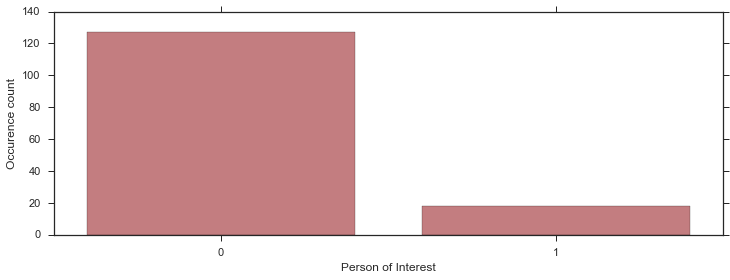

In [104]:
# total number of poi's in the dataset
poi = df.poi.value_counts()

plt.figure(figsize=(12,4));
sns.barplot(poi.index, poi.values, alpha=0.8, color=p[2]);
plt.xlabel('Person of Interest', fontsize=12);
plt.ylabel('Occurence count', fontsize=12);

print ('The dataset contains a total of %s POIs.' % sum(df['poi']))

In [170]:
print ('The dataset contains %s total records, with %s features for each record' % (df.shape[0], df.shape[1]-2))

The dataset contains 145 total records, with 25 features for each record


In [122]:
# df.describe(include = 'all')
all = df.count()

## features counts for the poi's
pois = df[df['poi'] == 1].count()

result = pd.concat([all, pois], axis=1)
result.columns = ['All Records','POIs']
result

,All Records,POIs
to_messages,86,14
restricted_stock_deferred,17,0
poi,145,18
deferred_income,48,11
salary,94,17
total_stock_value,125,18
expenses,94,18
deferral_payments,38,5
director_fees,16,0
loan_advances,3,1


### Selected Features

write-up... restricted_stock_deferred, director_fees, loan_advances and deferral_payments

omit email_address as feature...

In [160]:
features_list = ['poi','to_messages', 'deferred_income',
       'salary', 'total_stock_value', 'expenses', 'restricted_stock',
       'from_poi_to_this_person', 'long_term_incentive',
       'from_this_person_to_poi', 'total_payments', 'exercised_stock_options',
       'other', 'from_messages', 'bonus', 'shared_receipt_with_poi'] 

## Feature Distributions

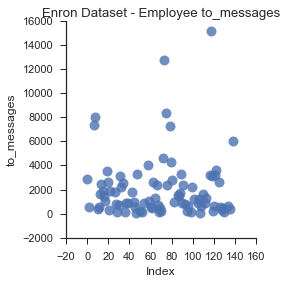

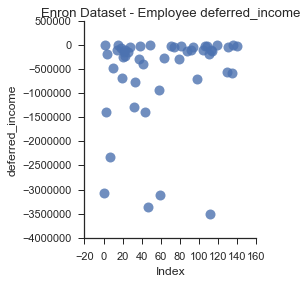

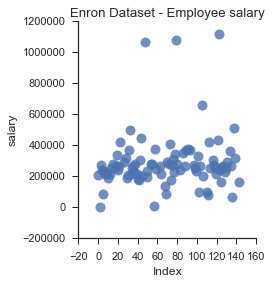

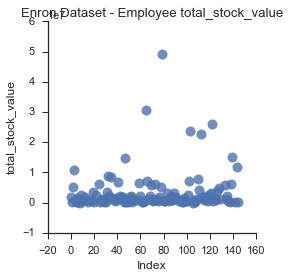

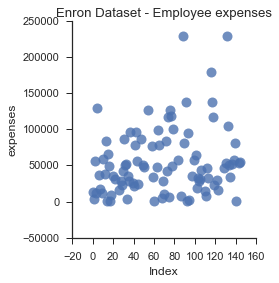

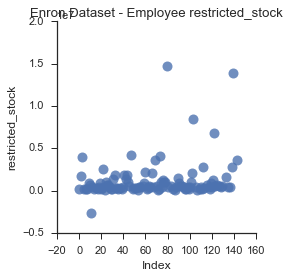

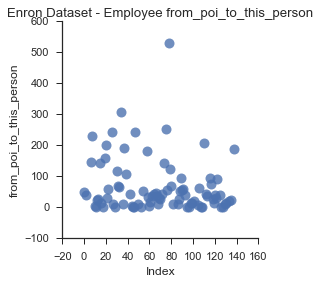

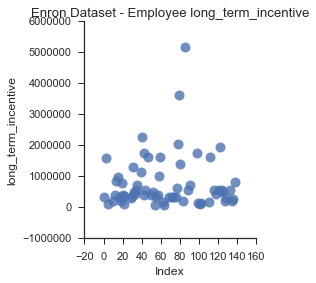

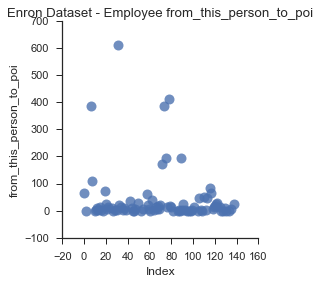

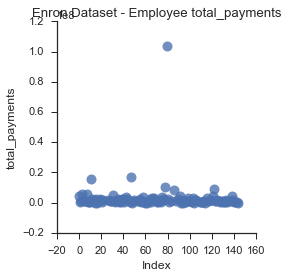

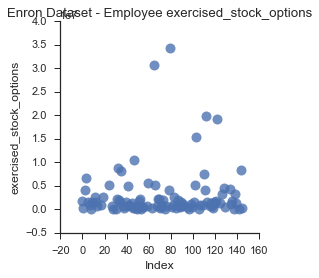

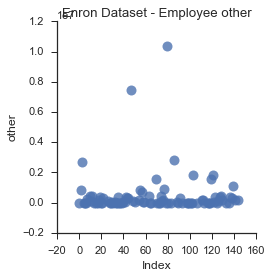

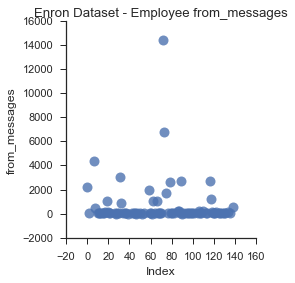

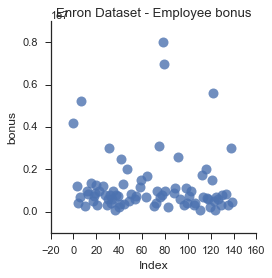

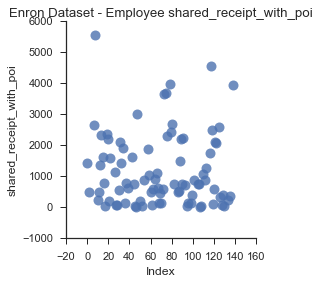

In [178]:
for feature in features_list[1:]: ##ignore first feature which is poi label
    try:
        sns.lmplot('index', feature, 
                   data=df,
                   fit_reg=False, 
                   scatter_kws={"marker": "D", 
                                "s": 100},
                  size=4);
        plt.title('Enron Dataset - Employee %s' % feature);
        plt.xlabel('Index');
        plt.ylabel(feature);
    except:
        pass


no feature scaling done...total payments could require log scale but random forests split handle these naturally...

## Feature Engineering

In [166]:
df['frac_bonus'] = df['bonus']/df['total_payments']
df['frac_salary'] = df['salary']/df['total_payments']
df['frac_tot_stock'] = df['total_stock_value']/df['total_payments']

df['frac_to_poi'] = df['from_this_person_to_poi']/df['to_messages']
df['frac_from_poi'] = df['from_poi_to_this_person']/df['to_messages']

In [167]:
new_features = ['frac_bonus','frac_salary','frac_tot_stock','frac_to_poi','frac_from_poi']

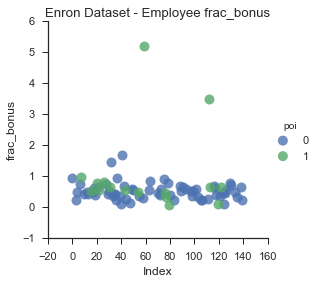

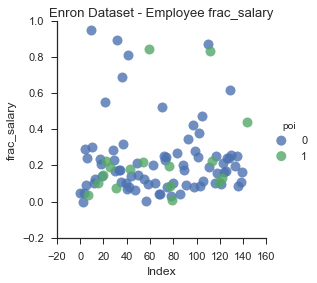

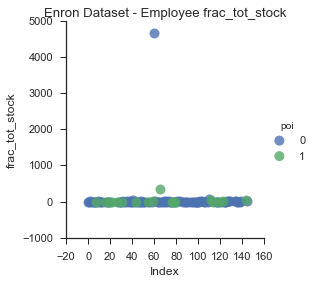

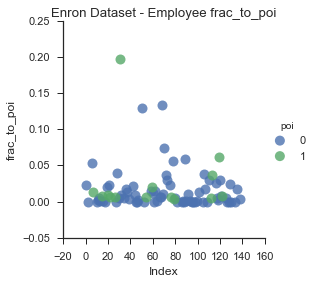

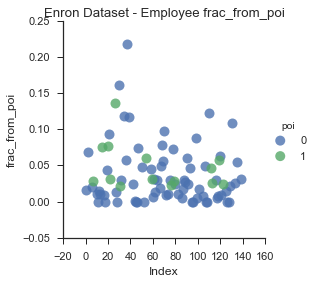

In [177]:
for feature in new_features:
    sns.lmplot('index', feature, 
           data=df, 
           fit_reg=False, 
           hue="poi",  
           scatter_kws={"marker": "D", 
                        "s": 100},
           size =4 )
    plt.title('Enron Dataset - Employee %s' % feature);
    plt.xlabel('Index');
    plt.ylabel(feature);

# Modelling

In [9]:
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
import tester

In [11]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [13]:
### SVM Model
pca_svm = Pipeline([('pca',PCA(n_components=2)),('scaler',StandardScaler()),('svm',svm.SVC())])
param_grid = ([{'svm__C': [1000,10000],
                'svm__gamma': [0.01,0.0001],
                'svm__degree':[2,3],
                'svm__kernel': ['linear','rbf','poly']}])

svm_clf = GridSearchCV(pca_svm,param_grid,scoring='recall').fit(features,labels).best_estimator_


# ### KNB Model
# pca_knb = Pipeline([('pca',PCA(n_components=2)),('scaler',StandardScaler()),('knb',KNeighborsClassifier())])
# param_grid = ([{'knb__n_neighbors': [4,5,6]}])
# knb_clf = GridSearchCV(pca_knb,param_grid,scoring='recall').fit(features,labels).best_estimator_


# ### RFST Model
# pca_rfst = Pipeline([('pca',PCA(n_components=2)),('scaler',StandardScaler()),
#                  ('rfst',RandomForestClassifier())])
# param_grid = ([{'rfst__n_estimators': [4,5,6]}])
# rfst_clf = GridSearchCV(pca_rfst,param_grid,scoring='recall').fit(features,labels).best_estimator_

In [14]:
print (svm_clf)
tester.test_classifier(svm_clf,my_dataset,features_list)

# print (knb_clf)
# tester.test_classifier(knb_clf,my_dataset,features_list)

# print (rfst_clf)
# tester.test_classifier(rfst_clf,my_dataset,features_list)

Pipeline(steps=[('pca', PCA(copy=True, n_components=2, whiten=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Pipeline(steps=[('pca', PCA(copy=True, n_components=2, whiten=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.88927	Precision: 0.81682	Recall: 0.21850	F1: 0.34477	F2: 0.25600
	Total predictions: 15000	True positives:  437	False positives:   98	False negatives: 1563	True negatives: 12902

